https://colab.research.google.com/github/changsin/DL/blob/main/notebooks/openpose_sign_language.ipynb#scrollTo=r1Bd4CVg-KMm

https://stackoverflow.com/questions/69154914/calculating-angles-of-body-skeleton-in-video-using-openpose

In [1]:
import sys
import os
import glob
import json
import numpy as np
from matplotlib import pyplot as plt
import cv2
import math
import re
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib as mpl 
from matplotlib import gridspec

mpl.rcParams['animation.ffmpeg_path'] = 'C:/Users/anjim/OneDrive/Documentos/ffmpeg/bin/ffmpeg.exe'

dir_path = 'D:/UTP Marcha/openpose/build/examples/tutorial_api_python'
sys.path.append(dir_path + '/../../python/openpose/Release');
os.environ['PATH']  = os.environ['PATH'] + ';' + dir_path + '/../../x64/Release;' +  dir_path + '/../../bin;'


import pyopenpose as op

In [143]:
def load_images(path):
    path = os.path.join(path,'*')
    files = glob.glob(path)
    # We sort the images in alphabetical order to match them
    #  to the annotation files
    files.sort()

    X_raw = []
    for file in files:
        image = cv2.imread(file) # BGR to RGB
        X_raw.append(np.array(image)[...,::-1])

    return X_raw

def from_json(path):
    file = open(path, 'r', encoding='utf-8')
    return json.load(file)

def extract_openpose_anns(ann_json):
    def extract_keypoints(ann_json):
        X = []
        Y = []
        C = []
        id = 0
        while id < len(ann_json):
            X.append(ann_json[id])
            Y.append(ann_json[id+1])
            C.append(ann_json[id+2])
            id += 3

        return np.array([X, Y, C])

    pose = {}
    # If there aren't people in frame, return zeros
    if len(ann_json['people']) > 0:
        kp_pose = extract_keypoints(ann_json['people'][0]['pose_keypoints_2d'])
        kp_face = extract_keypoints(ann_json['people'][0]['face_keypoints_2d'])
        kp_hand_left = extract_keypoints(ann_json['people'][0]['hand_left_keypoints_2d'])
        kp_hand_right = extract_keypoints(ann_json['people'][0]['hand_right_keypoints_2d'])

        pose['pose'] = kp_pose
        pose['face'] = kp_face
        pose['hand_left'] = kp_hand_left
        pose['hand_right'] = kp_hand_right
    else:
        X = [0] * 25
        Y = [0] * 25
        C = [0] * 25
        pose['pose'] = [X, Y, C]
        # ToDo: Fix for this keypoints
        pose['face'] = [[], [], []]
        pose['hand_left'] = [[], [], []]
        pose['hand_right'] = [[], [], []]

    return pose

def extract_pose_annotations(path):
  path = os.path.join(path,'*')
  files = glob.glob(path)
  files.sort()

  Y_raw = []
  for file in files:
    ann_json = from_json(file)
    ann = extract_openpose_anns(ann_json)
    Y_raw.append(ann)

  return Y_raw

def get_angle(edge1,  edge2, points):
    assert tuple(sorted(edge1)) in edges
    assert tuple(sorted(edge2)) in edges
    edge1 = set(edge1)
    edge2 = set(edge2)
    mid_point = edge1.intersection(edge2).pop()
    a = (edge1-edge2).pop()
    b = (edge2-edge1).pop()

    v1 = points[mid_point]-points[a]
    v2 = points[mid_point]-points[b]

    angle = (math.degrees(np.arccos(np.dot(v1,v2)
                                    /(np.linalg.norm(v1)*np.linalg.norm(v2)))))
    return angle

def getPartIndex(body_part):
    parts = {
        'Nose' : 0,
        'Neck' : 1,
        'RShoulder' : 2,
        'RElbow' : 3,
        'RWrist' : 4,
        'LShoulder' : 5,
        'LElbow' : 6,
        'LWrist' : 7,
        'MidHip' : 8,
        'RHip' : 9,
        'RKnee' : 10,
        'RAnkle' : 11,
        'LHip' : 12,
        'LKnee' : 13,
        'LAnkle' : 14,
        'REye' : 15,
        'LEye' : 16,
        'REar' : 17,
        'LEar' : 18,
        'LBigToe' : 19,
        'LSmallToe' : 20,
        'LHeel' : 21,
        'RBigToe' : 22,
        'RSmallToe' : 23,
        'RHeel' : 24,
        'Background' : 25
    }

    return parts[body_part]

def get_parts():
    return [
        'Nose',
        'Neck',
        'RShoulder',
        'RElbow',
        'RWrist',
        'LShoulder',
        'LElbow',
        'LWrist',
        'MidHip',
        'RHip',
        'RKnee',
        'RAnkle',
        'LHip',
        'LKnee',
        'LAnkle',
        'REye',
        'LEye',
        'REar',
        'LEar',
        'LBigToe',
        'LSmallToe',
        'LHeel',
        'RBigToe',
        'RSmallToe',
        'RHeel',
        'Background'
    ]

def extract_part_trajectory(body_part, Y):
    X_trajectory = []
    Y_trajectory = []
    C_trajectory = []
    for frame in Y:
        pose_keypoints = frame['pose']
        X_trajectory.append( pose_keypoints[0][getPartIndex(body_part)] )
        Y_trajectory.append( pose_keypoints[1][getPartIndex(body_part)] )
        C_trajectory.append( pose_keypoints[2][getPartIndex(body_part)] )

    return [ X_trajectory, Y_trajectory, C_trajectory ]

def get_body_edges(body_part):
    edges = []
    if body_part == 'RKnee':
        edges = [(10, 11), (9, 10)]
    elif body_part == 'LKnee':
        edges = [(13, 14), (12, 13)]

    else:
        assert False, 'Invalid body part'

    return edges

def get_body_angle(body_part, points):
    edge1, edge2 = get_body_edges(body_part)
    return get_angle(edge1, edge2, points)

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

def plot_pose_angles(X, Y, start_id=0, end_id=10, show_images = True):
  # fig, ax = plt.subplots()
  fig = plt.figure(figsize=(100, 100))

  for id in range(start_id, end_id):
    x = X[id]
    y = Y[id]

    points = np.asmatrix((y['pose'][0], y['pose'][1], y['pose'][2]))
    points = np.array(points.transpose())

    LKnee_angle = get_body_angle('LKnee', points)
    RKnee_angle = get_body_angle('RKnee', points)

    plt.ion()


    ax = fig.add_subplot(10, 1, id - start_id + 1)
    plt.axis('off')

    ax.imshow(x)

    ax.scatter(y['pose'][0], y['pose'][1])
    ax.scatter(y['face'][0], y['face'][1])
    ax.scatter(y['hand_left'][0], y['hand_left'][1])
    ax.scatter(y['hand_right'][0], y['hand_right'][1])
    ax.annotate(f'$\\bf{LKnee_angle:.2f}$', (y['pose'][0][getPartIndex('LKnee')], y['pose'][1][getPartIndex('LKnee')])  )
    ax.annotate(f'$\\bf{RKnee_angle:.2f}$', (y['pose'][0][getPartIndex('RKnee')], y['pose'][1][getPartIndex('RKnee')])  )
    # ax.legend()

    if not show_images:
      plt.close()
  # ax.invert_yaxis()

  return

def export_angles_images(X_raw, Y_raw, angles, output_folder):

    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)

    # loop over your images
    for (i, frame) in enumerate(X_raw):

        y = Y_raw[i]

        points = np.asmatrix((y['pose'][0], y['pose'][1], y['pose'][2]))
        points = np.array(points.transpose())

        LKnee_angle = get_body_angle('LKnee', points)
        RKnee_angle = get_body_angle('RKnee', points)

        fig = plt.figure()
        plt.axis('off')
        im = plt.imshow(frame)

        plt.scatter(y['pose'][0], y['pose'][1])
        plt.scatter(y['face'][0], y['face'][1])
        plt.scatter(y['hand_left'][0], y['hand_left'][1])
        plt.scatter(y['hand_right'][0], y['hand_right'][1])
        plt.annotate(f'$\\bf{LKnee_angle:.2f}$', (y['pose'][0][getPartIndex('LKnee')], y['pose'][1][getPartIndex('LKnee')])  )
        plt.annotate(f'$\\bf{RKnee_angle:.2f}$', (y['pose'][0][getPartIndex('RKnee')], y['pose'][1][getPartIndex('RKnee')])  )
        
        plt.savefig( os.path.join(output_folder, f'frame_{i}.png'), dpi=300 )

        plt.close()

def export_video_from_images(input_images, outpath_video, fps=30):
    img_array = []
    images_list = os.listdir(input_images)
    images_list.sort(key=natural_keys)

    for filename in images_list:
        img = cv2.imread( os.path.join(input_images, filename))
        height, width, _ = img.shape
        size = (width,height)
        img_array.append(img)

    #Create Video
    out = cv2.VideoWriter(outpath_video, cv2.VideoWriter_fourcc(*'MP4V'), fps, size)
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

def get_Knees_angles(y):
    LKnee_angles = []
    RKnee_angles = []

    for frame in y:
        points = np.asmatrix((frame['pose'][0], frame['pose'][1], frame['pose'][2]))
        points = np.array(points.transpose())
        LKnee_angles.append(get_body_angle('LKnee', points))
        RKnee_angles.append(get_body_angle('RKnee', points))

    return LKnee_angles, RKnee_angles

def save_animated_plot(arr_angles, outpath, fps=30):
    # create the figure and axis objects
    fig, ax = plt.subplots()

    # create empty lists for the x and y data
    x = []
    y = []

    def init():
        pass

    # function that draws each frame of the animation
    def animate(i, x, y):
        x.append(i)
        y.append(arr_angles[i])

        ax.clear()
        ax.plot(x, y)
        
        if i > 100:
            ax.set_xlim([i-100,i])
            # ax.set_ylim([0,10])


    # run the animation
    ani = FuncAnimation(fig, animate, frames=len(arr_angles), interval=(1/fps)*1000, repeat=False, init_func=init, fargs = (x, y))

    writervideo = animation.FFMpegWriter(fps=fps)
    ani.save(outpath, writer=writervideo)
    plt.close()

def save_static_plot(angles, output):
    plt.plot(angles)
    plt.xlabel('Frames')
    plt.ylabel('Angles')
    plt.savefig(output, dpi=100)
    plt.show()

def plot_trajectories(body_part, y, save_path=None):
    X, Y, _ = extract_part_trajectory(body_part, y)

    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 10))
    axs[0].plot(X)
    axs[0].set_xlabel('Frames')
    axs[0].set_ylabel('X Trajectory')
    axs[0].set_title(f'{body_part} X Trajectory')

    axs[1].plot(Y)
    axs[1].set_xlabel('Frames')
    axs[1].set_ylabel('Y Trajectory')
    axs[1].set_title(f'{body_part} Y Trajectory')

    if save_path:
        plt.savefig(save_path)

def plot_all_parts_trajectories(y, save_path=None, dpi=200):
    fig = plt.figure(figsize=(15, 15))
    gs = gridspec.GridSpec(nrows=5, ncols=5)

    for (i, body_part) in enumerate(get_parts()[:-1]):
        X, Y, _ = extract_part_trajectory(body_part, y)
        ax = fig.add_subplot(gs[i])
        ax.plot(X)
        ax.plot(Y)
        ax.set_xlabel('Frames')
        ax.set_ylabel('Trajectory')
        ax.set_title(f'{i} {body_part} Trajectory')
        ax.legend(['X', 'Y'])

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=dpi)

    plt.close()

In [ ]:
edges = {(0, 1), (0, 15), (0, 16), (1, 2), (1, 5), (1, 8), (2, 3), (3, 4), (5, 6), (6, 7), (8, 9), (8, 12), (9, 10), (10, 11), (11, 22), (11, 24), (12, 13), (13, 14), (14, 19), (14, 21), (15, 17), (16, 18), (19, 20), (22, 23)}

In [141]:
def process_folder(INPUT_FOLDER):
    Y_raw = extract_pose_annotations(f"INPUT/{INPUT_FOLDER}/json")
    X_raw = load_images(f"INPUT/{INPUT_FOLDER}/images")

    # Output folder
    OUTPUT_FOLDER = f'OUTPUT/{INPUT_FOLDER}'
    if not os.path.isdir(OUTPUT_FOLDER):
        os.mkdir(OUTPUT_FOLDER)

    # Extract Angles
    LKnee_angles, RKnee_angles = get_Knees_angles(Y_raw)

    # Export images with angles in keypoints
    OUTPUT_FOLDER_ANGLES = f'{OUTPUT_FOLDER}/{OUTPUT_FOLDER}_ANGLES'
    export_angles_images(X_raw, Y_raw, [LKnee_angles, RKnee_angles], OUTPUT_FOLDER_ANGLES)

    # Export video with angles in keypoints
    OUTPUT_VIDEO_ANGLES = os.path.join(OUTPUT_FOLDER, f'{INPUT_FOLDER}_ANGLES.mp4')
    export_video_from_images(OUTPUT_FOLDER_ANGLES, OUTPUT_VIDEO_ANGLES)

    # Export animated plot with angles
    OUTPUT_ANIMATED_VIDEO_RKNEE = os.path.join(OUTPUT_FOLDER, f'{INPUT_FOLDER}_ANIMATED_PLOT_RKNEE.mp4')
    save_animated_plot(RKnee_angles, OUTPUT_ANIMATED_VIDEO_RKNEE)

    OUTPUT_ANIMATED_VIDEO_LKNEE = os.path.join(OUTPUT_FOLDER, f'{INPUT_FOLDER}_ANIMATED_PLOT_LKNEE.mp4')
    save_animated_plot(LKnee_angles, OUTPUT_ANIMATED_VIDEO_LKNEE)

    # Export static plot
    OUTPUT_STATIC_PLOT_RKNEE = os.path.join(OUTPUT_FOLDER, f'{INPUT_FOLDER}_STATIC_PLOT_RKNEE.png')
    save_static_plot(RKnee_angles, OUTPUT_STATIC_PLOT_RKNEE)

    OUTPUT_STATIC_PLOT_LKNEE = os.path.join(OUTPUT_FOLDER, f'{INPUT_FOLDER}_STATIC_PLOT_LKNEE.png')
    save_static_plot(LKnee_angles, OUTPUT_STATIC_PLOT_LKNEE)

    # Export all trajectories plot
    OUTPUT_STATIC_PLOT_LKNEE = os.path.join(OUTPUT_FOLDER, f'{INPUT_FOLDER}_ALL_TRAJECTORIES.png')
    plot_all_parts_trajectories(Y_raw, OUTPUT_STATIC_PLOT_LKNEE)

In [144]:
# TODO: Skip if there aren't people in frame
# TODO: Proccess multiplee folders

process_folder('IMG_2691')

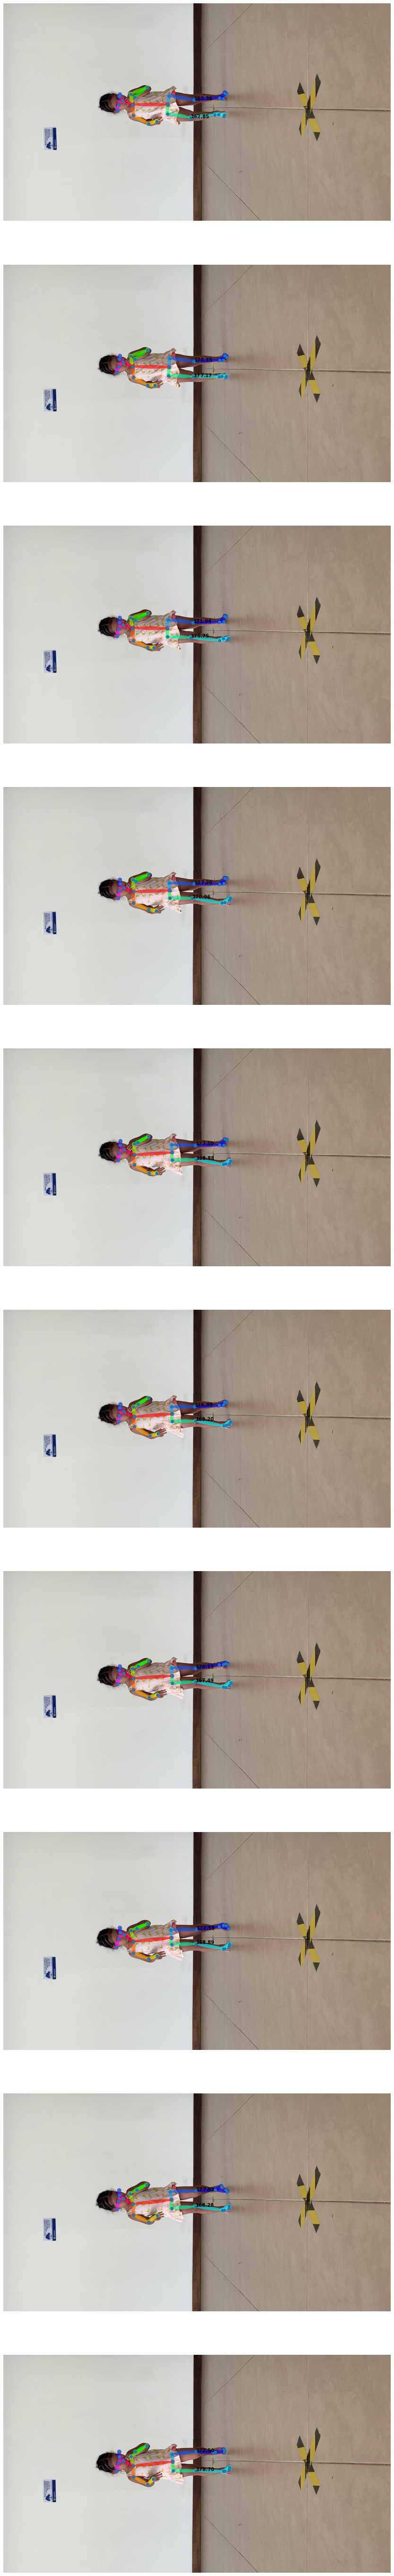

In [84]:
plot_pose_angles(X_raw, Y_raw, start_id=0, end_id=10)